<a href="https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this tutorial, we will build CNN models to classify images.** \\
Notebook inspired by: \\
1) https://www.kaggle.com/code/zeadomar/breast-cancer-detection-with-cnn/notebook \\
2) https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code \\
3) https://cs231n.github.io/convolutional-networks/ \\

**Introduction**

Motivation: Regular Neural Nets don't scale well to full images. \\
ConvNets: Take advantage that inputs consists of image. \\
Layers of ConvNet have neurons arranged in 3 dimensions: **(width, height, depth)** 

**Building the model**
1.   Main operations: Convolution, Pooling, and activation (prediction)

  Pooling: Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.


cnn-dims-3.svg


**1. Feature extraction using convolution** \\

---

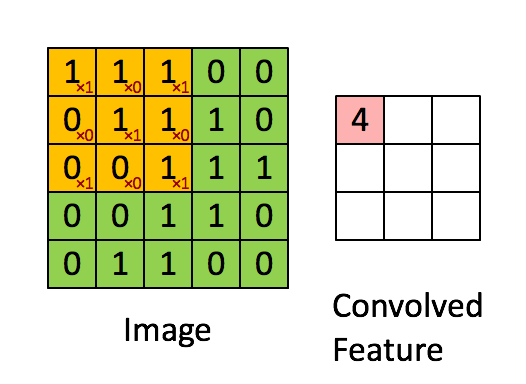

**2. Pooling to reduce complexity** \\

---

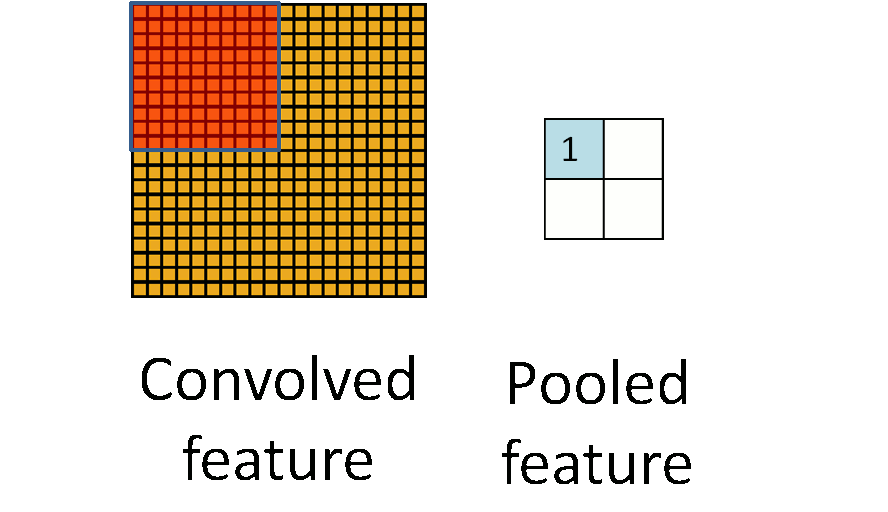

$$ output= \dfrac{W-F+2P}{S} + 1$$
where $W$ is the input size, \\
$F$ is the filter size, \\
$P$ is the padding size, \\
$W$ is the stride size. \\

**1) Identification of handwritten digits (MNIST)**


---



In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Loading the mnist images
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)
print(test_images.shape) # (10000, 28, 28)
print(test_labels.shape) # (10000,)

In [ ]:
# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, train_images.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = train_images[j], train_labels[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

In [ ]:
# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5]. 
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (train_images.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
model = Sequential()
model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers
model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(num_classes, activation='softmax')) # output layer

# Different syntax, different padding
model_2 = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

In [ ]:
# Summary of the model 
model.summary()

In [ ]:
model_2.summary()

In [ ]:
# Plot model 
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)


In [ ]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 50

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# Fitting the model
history = model.fit(
  train_images,
  train_labels, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

In [ ]:
# availale keys in history
print(history.history.keys())

In [ ]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

In [ ]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

**2) Using AlexNet on the Fashion MNIST dataset** \\
Inspired by: https://github.com/eweill/keras-deepcv \\
AlexNet Paper: 
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

**The Alexnet model**
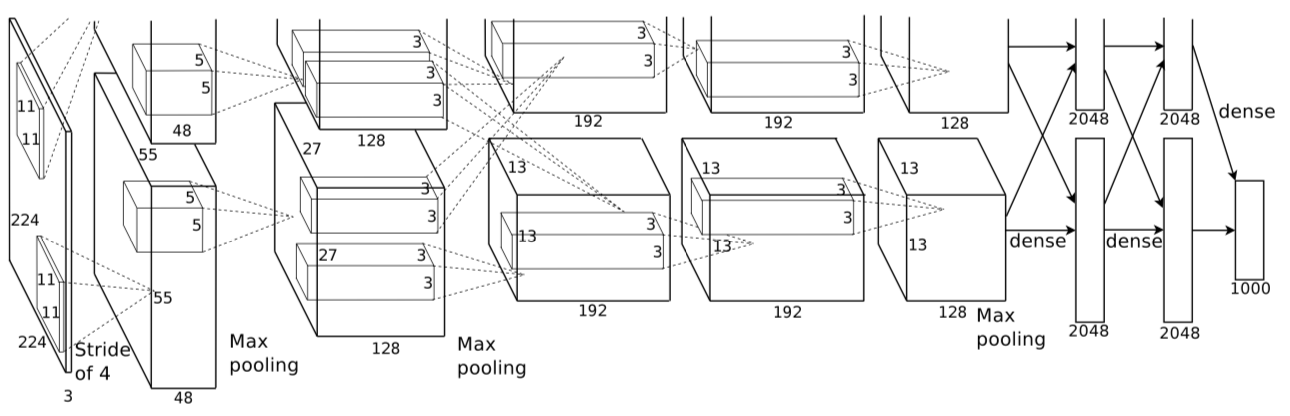

In [ ]:
# Load Fashion MNIST dataset
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
CLASS_DESC = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = 10

In [ ]:
# Visualize the dataset
plt.figure(figsize=(10,10))
sample_img_idx = np.random.randint(0, x_train.shape[0]+1, 20)
for i, j in enumerate(sample_img_idx):
    image, label = x_train[j], y_train[j]
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(CLASS_DESC[label])
    plt.axis('off')

In [ ]:
# Pre-process data
train_labels = to_categorical(y_train, num_classes)
test_labels  = to_categorical(y_test, num_classes)

train_images = (x_train / 255)
test_images = (x_test / 255)

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

assert train_images.shape == (60000, 28, 28, 1)
assert test_images.shape == (10000, 28, 28, 1)
assert train_labels.shape == (60000, 10)
assert test_labels.shape == (10000, 10)

In [ ]:
# Define the AlexNet model
def alexnet_model(img_shape=(224, 224, 1), n_classes=10):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer='l2'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	return alexnet

In [ ]:
# Create model and get summary
model = alexnet_model(img_shape=(28, 28, 1), n_classes = num_classes)
model.summary()

In [ ]:
# Compile model
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
		optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
		metrics=['accuracy'])

In [ ]:
# Data augmentation (optional: for performance improvement)
datagen = ImageDataGenerator(
  featurewise_center=False,	# set input mean to 0 over dataset
  samplewise_center=False,	# set each sample mean to 0
  featurewise_std_normalization=False,	# divide inputs by std of dataset
  samplewise_std_normalization=False,	#divide each input by its std
  zca_whitening=False,	# apply ZCA whitening
  rotation_range=0,	# randomly roate images in the range (degrees, 0 to 180)
  width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
  height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
  horizontal_flip=True,	# randomly flip images horizontally
  vertical_flip=False)	# randomly flip images vertically

datagen.fit(train_images)

In [ ]:
# Train model
epochs = 3
# Train the data with batches generated by datagen.flow()
history = model.fit(datagen.flow(train_images, train_labels,
                  batch_size=128),
                  epochs=epochs,
                  verbose = 1,
                  validation_data=(test_images, test_labels)
  )

In [ ]:
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions for all test images
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')